In [14]:
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import _name_estimators
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import xgboost as xgb

# Majority Voting

In [2]:
# majority voting on predicted labels, each classifer with own weights in the ensembled prediction
# since the third classifer as weight 3x the first two, this voting is (0, 0, 1, 1, 1) = 1
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [3]:
# majority voting can also be done in probabilities
predicted_probabilities = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])

# ensemble probability just averages the probability of each label with weights
ensembled_probabilities = np.average(predicted_probabilities, axis=0, weights=[0.2, 0.2, 0.6])
print(ensembled_probabilities)
np.argmax(ensembled_probabilities)

[0.58 0.42]


0

In [4]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        # assign key and name for the ensembled classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote    # vote with predicted label or probability
        self.weights = weights

    def fit(self, X, y):
        # check that we are voting with label or probability
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")

        # check that each classifier has weight
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal; got {len(self.weights)} weights, {len(self.classifiers)} classifiers')

        # use LabelEncoder to ensure class labels start at 0, since np.argmax() counts start at 0
        self.labelencoder_ = LabelEncoder()
        self.labelencoder_.fit(y)
        self.classes_ = self.labelencoder_.classes_
        self.fitted_classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelencoder_.transform(y))  # fit the base classifier with the encoded label (label start at 0)
            self.fitted_classifiers_.append(fitted_clf)
        
        return self

    def predict(self, X):
        if self.vote == 'probability':
            majority_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # each classifier predicts a label
            predictions = np.asarray([clf.predict(X) for clf in self.fitted_classifiers_]).T

            # vote on the labels with weights
            majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        
        # transform back to original labels
        majority_vote = self.labelencoder_.inverse_transform(majority_vote)
        return majority_vote

    def predict_proba(self, X):
        # each classifier predict label probabilities
        probas = np.asarray([clf.predict_proba(X) for clf in self.fitted_classifiers_])
        # average the probability for each label with classifier weights
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    # function to get the parameters of each classifier
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items(): out[f'{name}__{key}'] = value
            return out

In [5]:
# load data and only use 2 features (to be more challenging for individual classifiers to illustrate merit of ensemble)
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]  # only use two class samples for now

# encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [6]:
# construct the base classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# only LR and KNN need standardization, no need for tree
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_names = ['Logistic Regression', 'Tree', 'KNN']

# train and evaluate the classifiers
print('10-fold cross validation:\n')
for clf, name in zip([pipe1, clf2, pipe3], clf_names):
    # cross-validation using kfold, using ROC AUC metric, for each classifier
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')

    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{name}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [7]:
# add the ensemble majority voting
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_names += ['Majority voting']
all_classifiers = [pipe1, clf2, pipe3, mv_clf]

for clf, name in zip(all_classifiers, clf_names):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')

    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{name}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


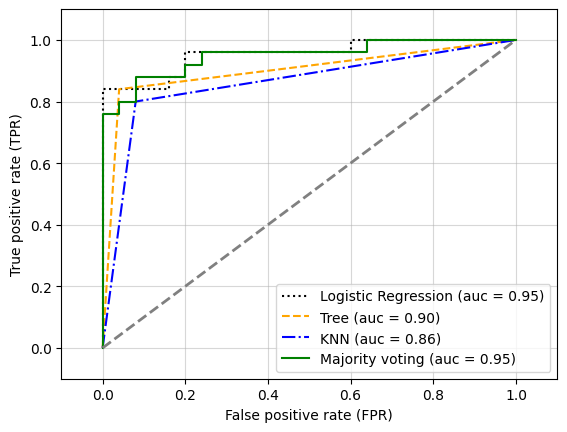

In [8]:
# plot the ROC curve for ensembled classifier on the test set

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, name, color, ls in zip(all_classifiers, clf_names, colors, linestyles):
    # predict on test set
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

    # get roc curve values
    fpr, tpr, threshholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)

    # plot ROC curve
    plt.plot(fpr, tpr, color=color, linestyle=ls, label=f'{name} (auc = {roc_auc:.2f})')

plt.legend(loc='best')

# plot random guessing roc
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [9]:
# tune the parameters for each base classifier
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

# can directly tune via the ensembled classifier
gs = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
gs.fit(X_train, y_train)

# print each combination of hyperparameter, and its auc
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    mean_score = gs.cv_results_['mean_test_score'][r]
    std_dev = gs.cv_results_['std_test_score'][r]
    params = gs.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

print(f'Best parameters: {gs.best_params_}')
print(f'ROC AUC: {gs.best_score_:.3f}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.983


# Bagging

In [10]:
# get data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash', 'Magnesium','Total phenols', 'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

# remove 1 class (only use 2 classes)
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
# only use 2 features
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [11]:
# encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [12]:
# bagging is usually used on a ensemble of tree classifiers
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

# check the accuracy of tree vs bagging
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train_accuracy = accuracy_score(y_train, y_train_pred)
tree_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Tree train/test accuracies {tree_train_accuracy:.3f}/{tree_test_accuracy:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train_accuracy = accuracy_score(y_train, y_train_pred)
bag_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies {bag_train_accuracy:.3f}/{bag_test_accuracy:.3f}')

Tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


# AdaBoost

In [13]:
# AdaBoost trains simple classifiers (usually simple tree), and gives misclassified samples greater weights so the next classifier can improve
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

# check the accuracy of tree vs adaboost
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train_accuracy = accuracy_score(y_train, y_train_pred)
tree_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Tree train/test accuracies {tree_train_accuracy:.3f}/{tree_test_accuracy:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train_accuracy = accuracy_score(y_train, y_train_pred)
ada_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies {ada_train_accuracy:.3f}/{ada_test_accuracy:.3f}')


Tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


# Gradient Boost

In [16]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)
gbm = model.fit(X_train, y_train)

# predict
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

# evaluate
gbm_train_accuracy = accuracy_score(y_train, y_train_pred)
gbm_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'XGBoost train/test accuracies {ada_train_accuracy:.3f}/{ada_test_accuracy:.3f}')

XGBoost train/test accuracies 1.000/0.917
